In [1]:
import pandas as pd

In [2]:
teams = pd.read_csv("../data/MTeams.csv")

In [3]:
slots = pd.read_csv("../data/MNCAATourneySlots.csv")
slots = slots[slots.Season == 2023]

In [4]:
seeds = pd.read_csv("../data/MNCAATourneySeeds.csv")

# remove play-ins
seeds["Seed"] = seeds["Seed"].str[0:3]
seeds = seeds.drop_duplicates(["Season", "Seed"])
seeds["Seed"] = seeds["Seed"].astype(str)

In [5]:
predictions = pd.read_csv("../submissions/sub1_3_13.csv")
predictions[['Season', 'Team1', 'Team2']] = predictions['ID'].str.split('_', expand=True)
predictions = predictions[predictions["Pred"] != .5] 
predictions["Team1"] = predictions["Team1"].astype(int) 
predictions["Team2"] = predictions["Team2"].astype(int) 
predictions["Season"] = predictions["Season"].astype(int) 

seeds_t1 = seeds.copy()
seeds_t1.columns = ["Season", "t1_seed", "Team1"]
predictions = predictions.merge(seeds_t1, how="inner", on=["Season", "Team1"]) # inner results in removing playin teams from above 

seeds_t2 = seeds.copy()
seeds_t2.columns = ["Season", "t2_seed", "Team2"]
predictions = predictions.merge(seeds_t2, how="inner", on=["Season", "Team2"])

# filter out women for now
predictions = predictions[predictions.Team1 < 2000]

In [6]:
predictions2 = predictions.copy()
predictions2 = predictions[['ID', 'Pred', 'Season', 'Team2', 'Team1', 't2_seed', 't1_seed']]
predictions2.columns = ['ID', 'Pred', 'Season', 'Team1', 'Team2', 't1_seed', 't2_seed']
predictions2["Pred"] = 1 - predictions2["Pred"]
predictions = pd.concat([predictions, predictions2], axis=0)

In [8]:
predictions.columns = ['ID', 'prob_strong_seed', 'Season', 'StrongTeam', 'WeakTeam', 'StrongSeed', 'WeakSeed']


### repeat

In [13]:
def get_round(slots, round):
    return slots[slots.Slot.str[1] == str(round)]

import numpy as np
def random_choice(p):
    return np.random.choice([1, 0], p=[p, 1 - p])

def get_round_slots(slots):
    r1_slots = get_round(slots, 1)
    r2_slots = get_round(slots, 2)
    r3_slots = get_round(slots, 3)
    r4_slots = get_round(slots, 4)
    r5_slots = get_round(slots, 5)
    r6_slots = get_round(slots, 6)
    return r1_slots, r2_slots, r3_slots, r4_slots, r5_slots, r6_slots




In [19]:
r1_slots, r2_slots, r3_slots, r4_slots, r5_slots, r6_slots = get_round_slots(slots)


In [20]:
def predict_round1(r1_slots, predictions):
    # get probs
    r1_slots = r1_slots.merge(predictions, how="left", on = ["Season", "StrongSeed", "WeakSeed"])
    r1_slots = r1_slots[r1_slots.prob_strong_seed.notnull()]

    # Get whether strong seed wins
    r1_slots['strong_seed_wins'] = r1_slots['prob_strong_seed'].apply(lambda x: random_choice(x))

    # get slot / winners
    r1_slots["winner_team"] = np.where(r1_slots.strong_seed_wins == 1, r1_slots.StrongTeam, r1_slots.WeakTeam)
    r1_winners = r1_slots[["Slot", "winner_team"]]
    return r1_winners

def predict_round(previous_winners, slots_for_round, predictions):

    previous_winners1 = previous_winners.copy()
    previous_winners1.columns = ["StrongSeed", "StrongTeam"]

    slots_for_round = slots_for_round.merge(previous_winners1, how="left", on=["StrongSeed"])

    previous_winners2 = previous_winners.copy()
    previous_winners2.columns = ["WeakSeed", "WeakTeam"]

    slots_for_round = slots_for_round.merge(previous_winners2, how="left", on=["WeakSeed"])

    key = ["Season", "StrongTeam", "WeakTeam"]
    slots_for_round = slots_for_round.merge(predictions[key +["prob_strong_seed"]], how="left", on = key)

    slots_for_round['strong_seed_wins'] = slots_for_round['prob_strong_seed'].apply(lambda x: random_choice(x))

    slots_for_round["winner_team"] = np.where(slots_for_round.strong_seed_wins == 1, slots_for_round.StrongTeam, slots_for_round.WeakTeam)
    winners = slots_for_round[["Slot", "winner_team"]]

    return winners




In [75]:
def simulate():
    r1_winners = predict_round1(r1_slots, predictions)
    r2_winners = predict_round(r1_winners, r2_slots, predictions)
    r3_winners = predict_round(r2_winners, r3_slots, predictions)
    r4_winners = predict_round(r3_winners, r4_slots, predictions)
    r5_winners = predict_round(r4_winners, r5_slots, predictions)
    r6_winners = predict_round(r5_winners, r6_slots, predictions)

    return [r1_winners, r2_winners, r3_winners, r4_winners, r5_winners, r6_winners]

In [66]:
r4_winners

,Slot,winner_team
0,R4W1,1243.0
1,R4X1,1112.0
2,R4Y1,1179.0
3,R4Z1,1242.0


In [120]:
champions = []

for _ in tqdm.tqdm(range(1000)):
    winners_list = simulate()
    r4_winners = winners_list[3]
    df = r4_winners.merge(teams, how="left", left_on="winner_team",right_on="TeamID")
    champions.extend(df.TeamName.tolist())

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 181/1000 [00:11<00:49, 16.65it/s]

/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_29062/1820958958.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(champion_sim.index, rotation=45)


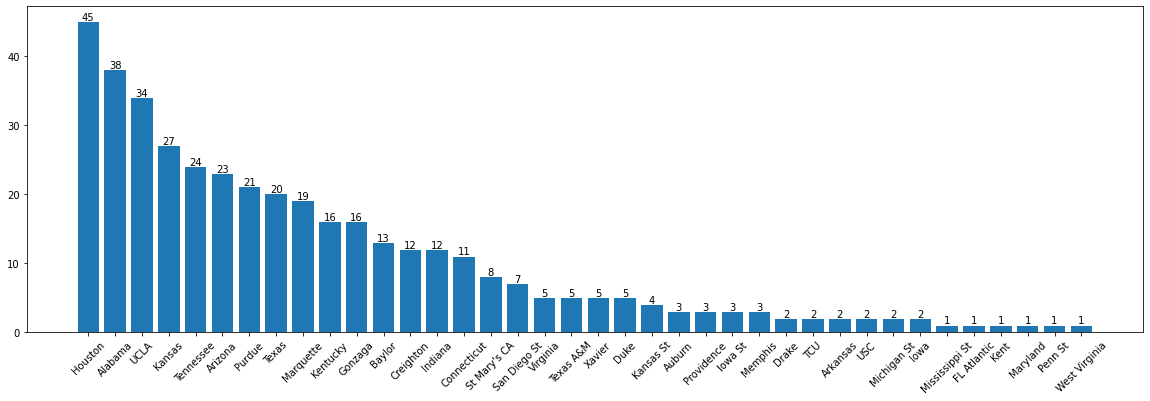

In [ ]:
champion_sim = pd.DataFrame(champions, columns = ["champion"])
champion_sim = pd.DataFrame(champion_sim.champion.value_counts())

from matplotlib import pyplot as plt
# plt.figure(figsize=(20, 6))
# plt.bar(champion_sim.index, champion_sim['champion'])

fig, ax = plt.subplots(figsize=(20, 6))
bar_container = ax.bar(champion_sim.index, champion_sim['champion'])
ax.bar_label(bar_container)
ax.set_xticklabels(champion_sim.index, rotation=45)
ax.tick_params(axis='x', rotation=45)




/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_29062/4101639691.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(champion_sim_one_quad.index, rotation=45)


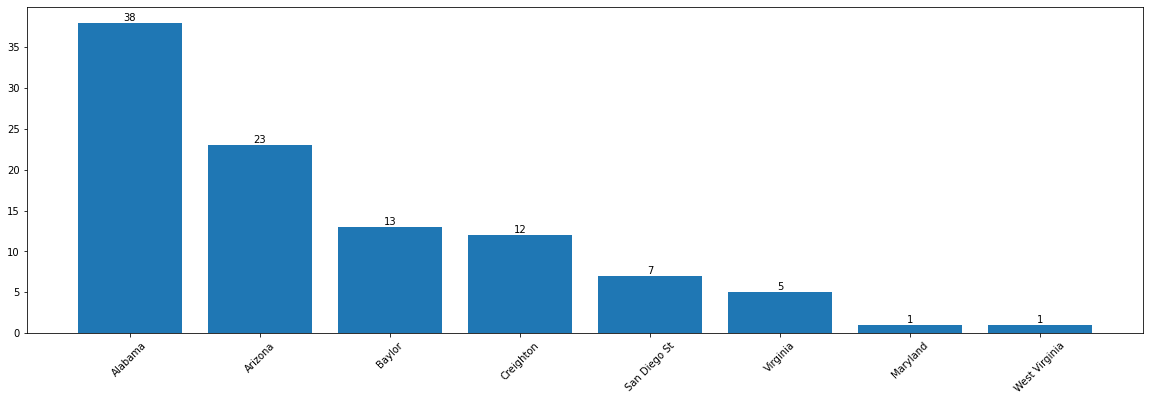

In [ ]:
champion_sim_one_quad = champion_sim[champion_sim.index.isin(["Alabama",
                                      "Arizona",
                                      "Baylor",
                                      "Virginia",
                                      "Creighton",
                                      "Maryland",
                                      "West Virginia",
                                      "Utah St",
                                      "NC State",
                                      "Col Charleston",
                                      "Furman",
                                      "Missouri",
                                      "San Diego St"
                                    ])]



fig, ax = plt.subplots(figsize=(20, 6))
bar_container = ax.bar(champion_sim_one_quad.index, champion_sim_one_quad['champion'])
ax.bar_label(bar_container)
ax.set_xticklabels(champion_sim_one_quad.index, rotation=45)
ax.tick_params(axis='x', rotation=45)